# Проектная работа

**Цель** - Подготовить исследование рынка объектов общественного питания (в дальнейшем ООП) в Москве для того, чтобы понять нужно ли открывать "робокафе", где и с какими вводными его лучше открыть


## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Задание палетки и темы для графиков

sns.set_theme(style="whitegrid", palette="pastel") 

## Задание пользовательских функций

In [3]:
def df_check(df):
    # функция для проверки количества дубликатов в датафрейме 
    # и количества пропусков по столбцам
    print(f'Количество дубликатов в датафрейме равно {df.duplicated().sum()}')
    print('Пропуски в датафрейме:')
    print(df.isna().sum())

## Предобработка данных

Для начала посмотрим на наш датасет

In [4]:
test_data = pd.read_csv('rest_data.csv')

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [6]:
test_data.sample(5, random_state=1)

,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, стро...",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42


В датасете содержатся следующие данные:
1. Столбец **id** - идентификатор объекта ООП, формат int64
2. Столбец **object_name** -  название объекта общественного питания, формат object
3. Столбец **chain** -является ли ресторан сетевым, формат object
4. Столбец **object_type** - тип ООП, формат object
5. Столбец **address** - адрес ООП, формат object
6. Столбец **number** - количество посадочных мест, формат int64

### Пропуски и дубликаты

На первый взгляд исходя из info пропусков данных нет. Убедимся в отсутствии пропускоы и дубликатов, воспользовавшись пользовательской функцией **df_check**

In [7]:
df_check(test_data)

Количество дубликатов в датафрейме равно 0
Пропуски в датафрейме:
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


Явные дубликаты и пропуски отсутствуют. Проверим какие значения хранятся в столбцах **chain** и **object_type** (там могут неявные дубликты и опечатки)

In [8]:
test_data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [9]:
test_data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Неявных дубликатов нет, все названия написаны с маленькой буквы, что устраивает нас для дальнейшего исследования

### Переименование столбцов

Переименуем столбец **seats** так, чтобы он имел название, отражающее количество посадочных мест

In [10]:
test_data = test_data.rename(columns={'number':'seats'})

### Работа с неявными дубликатами

Солбец **object_name** приведем к нижнему регистру, так, как некоторые названия записаны в верхнем, это избавит нас от множества сущностей

In [11]:
test_data['object_name'] = test_data['object_name'].str.lower()

Также заметно, что в столбце **object_name** некоторые названия записаны по разному, например макдональдс. Сложно найти все такие неявные дубликаты, приведем к одной сущности самые часто повторяющиеся

In [12]:
test_data.groupby('object_name')['id'].count().sort_values(ascending=False)

object_name
столовая                                                       321
кафе                                                           278
шаурма                                                         250
шоколадница                                                    158
kfc                                                            155
                                                              ... 
православный центр образования святителя николая чудотворца      1
правда кафе                                                      1
правdа кафе                                                      1
ппк пропиком                                                     1
1-й мок                                                          1
Name: id, Length: 9924, dtype: int64

In [13]:
# считаем количество неявных дубликатов
test_data['object_name'][test_data['object_name'].str.contains('Макдон', case=False)].unique()

array(['макдоналдс', 'ресторан «макдоналдс»',
       'предприятие быстрого обслуживания «макдоналдс»',
       'москва - макдоналдс', 'кафе макдоналдс', 'кафе «макдоналдс»',
       'ресторан«макдоналдс»'], dtype=object)

In [14]:
# заменяем строки с неявными дубликатами
test_data['object_name'] = test_data['object_name'].str.replace(r'(^.*макдон.*$)', 'макдоналдс')
test_data['object_name'][test_data['object_name'].str.contains('Макдон', case=False)].unique()

array(['макдоналдс'], dtype=object)

In [15]:
test_data['object_name'][test_data['object_name'].str.contains('kfc', case=False)].unique()

array(['kfc', 'кафе «kfc»', 'ростикс kfc', 'закусочная kfc',
       'kfc волгоградский', 'кафе kfc', 'пбо «kfc покрышкина»', 'kfc.',
       'предприятие быстрого обслуживания «kfc»', 'закусочная «kfc»',
       'ресторан kfc', 'пбо «kfc»', 'ресторан «kfc»', 'fridays kfc',
       'ресторан быстрого питания kfc'], dtype=object)

In [16]:
test_data['object_name'] = test_data['object_name'].str.replace(r'(^.*kfc.*$)', 'kfc')
test_data['object_name'][test_data['object_name'].str.contains('Макдон', case=False)].unique()

array(['макдоналдс'], dtype=object)

In [17]:
test_data['object_name'][test_data['object_name'].str.contains('шоколадница', case=False)].unique()

array(['шоколадница', 'шоколадница кофе хаус', 'кофейня «шоколадница»',
       'кафе «шоколадница»', 'кофейня шоколадница',
       'шоколадница экспресс', 'шоколадница кофемания'], dtype=object)

In [18]:
test_data['object_name'] = test_data['object_name'].str.replace(r'(^.*шоколадница.*$)', 'шоколадница')
test_data['object_name'][test_data['object_name'].str.contains('шоколадница', case=False)].unique()

array(['шоколадница'], dtype=object)

### Поиск и удаление строк дубликатов (но с разными id)

Посмотрим на количество дубликатов в датафрейме и получим их индексы

In [19]:
test_data[['object_name', 'chain', 'object_type', 'address', 'seats']].duplicated().sum()

85

Всего 82 строки повторяющие друг друга, за исключением id, я знаю что в Москве в одном торговом центре может быть 2 одинаковых заведения, например макдональдса, однако это случается крайне редко. Поэтому я приняла решение удалить данные дубликаты. Найдем индексы дубликатов и удалим их из датафрейма

In [20]:
dupl_index = test_data[test_data[['object_name', 'chain', 'object_type', 'address', 'seats']].duplicated()].index


In [21]:
test_data = test_data.drop(dupl_index)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15281 non-null  int64 
 1   object_name  15281 non-null  object
 2   chain        15281 non-null  object
 3   object_type  15281 non-null  object
 4   address      15281 non-null  object
 5   seats        15281 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.7+ KB


Удалили 85 строк дубликатов

### Вывод
В процессе знакомства с данными не было найдено проблем (дубликатов, пропусков и т.д.). Названия колонок написаны в стиле snake-case, удобно читаются и передают суть информации, лежащей в них, за исключением колонки с количеством посадочных мест, которая была переименована. Также столбец **object_name** был приведен к нижнему регистру и из него были убраны дубликаты по макдональдсу, kfc, шоколаднице. Также были удалены 85 полных дубликатов (но у них были разные id)

## Анализ данных

### Анализ объектов общественного питания по количеству

Поскольку в нашем датасете всего 9 видов объектов общественного питания, то выберем в качестве визуализации столбчатую диаграмму и проанализируем её. Для начала сгруппируем данные по виду ООП и найдем количество заведений каждого вида.

In [22]:
oop_count = test_data.groupby('object_type')['id'].count().sort_values(ascending=False).reset_index()

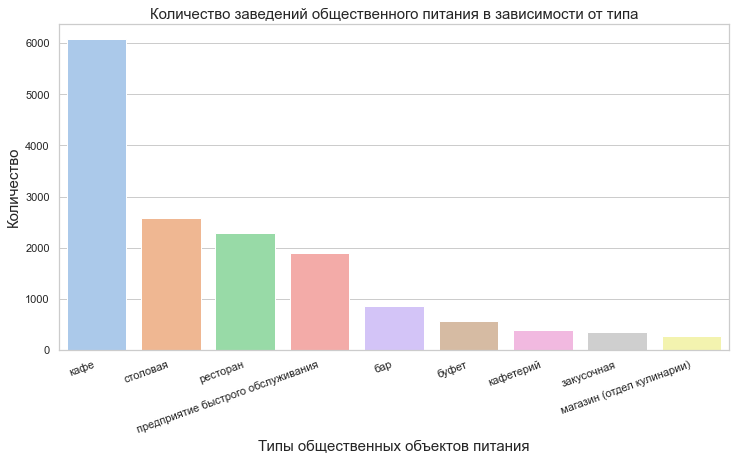

In [23]:
# строим барплот, наводим красоту

plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='object_type', y='id', data=oop_count)
ax.set_title('Количество заведений общественного питания в зависимости от типа', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Количество', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

In [24]:
oop_count

,object_type,id
0,кафе,6071
1,столовая,2584
2,ресторан,2282
3,предприятие быстрого обслуживания,1897
4,бар,855
5,буфет,576
6,кафетерий,395
7,закусочная,348
8,магазин (отдел кулинарии),273


По графику мы видим, что большинство объектов общественного питания в Москве это кафе (больше 6000). С большим отрывом от кафе и почти наравне идут столовые, рестораны и преприятия быстрого обслуживания. На последнем месте находятся отделы кулинарии в магазинах, на втором и третьем с конца - закусочные и кафетерии. 

### Анализ количества ООП с разбивкой на сетевые и несетевые заведения 

Для ответа на данный вопрос построим круговую диаграмму

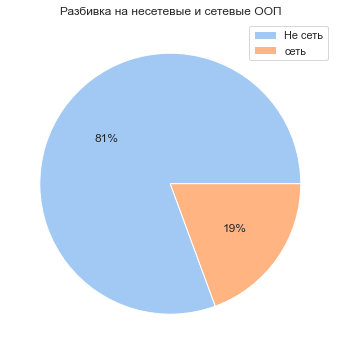

In [25]:
plt.figure(figsize=(12, 6)) 
plt.pie(test_data.groupby('chain')['id'].count().sort_values(ascending=False),
         autopct='%.0f%%')
plt.title('Разбивка на несетевые и сетевые ООП')
plt.legend(['Не сеть', 'сеть'])
plt.show()

Итого, в Москве всего лишь 19 процентов мест общественного питания принадлежат сетевым предприятиям! 

### Поиск вида объекта общественного питания, для которого характерно сетевое распространение

Построим график для сетевых заведений 

In [26]:
chain_grouped = test_data[test_data['chain'] == 
    'да'].groupby('object_type')['id'].count().sort_values(ascending=False).reset_index()

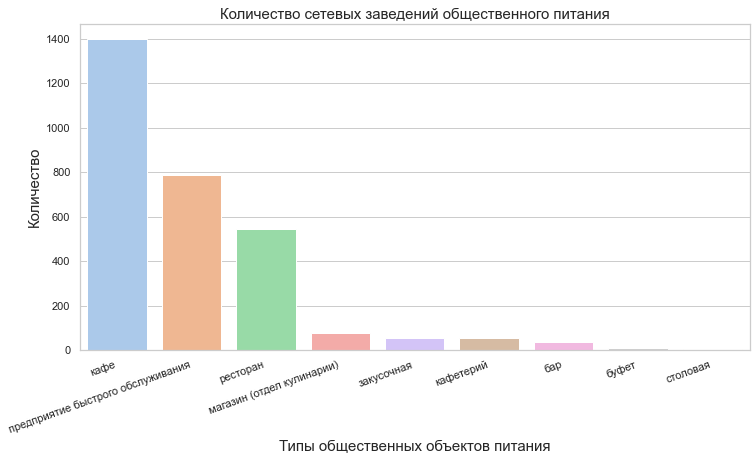

In [27]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='object_type', y='id', data=chain_grouped)
ax.set_title('Количество сетевых заведений общественного питания', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Количество', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

Среди сетевых заведений на первом месте также находятся кафе, затем идут предприятия быстрого обслуживания, затем рестораны. Замыкают рейтинг столовые, буфеты и бары

И найдем долю сетевых заведений от общего количества по разбивке на тип предприятия

In [28]:
((test_data[test_data['chain'] == 
           'да'].groupby('object_type')['id'].count() / test_data.groupby('object_type')['id'].count()) *100
).sort_values(ascending=False).reset_index()

,object_type,id
0,предприятие быстрого обслуживания,41.539273
1,магазин (отдел кулинарии),28.571429
2,ресторан,23.794917
3,кафе,22.994564
4,закусочная,16.091954
5,кафетерий,13.164557
6,бар,4.327485
7,буфет,1.909722
8,столовая,0.116099


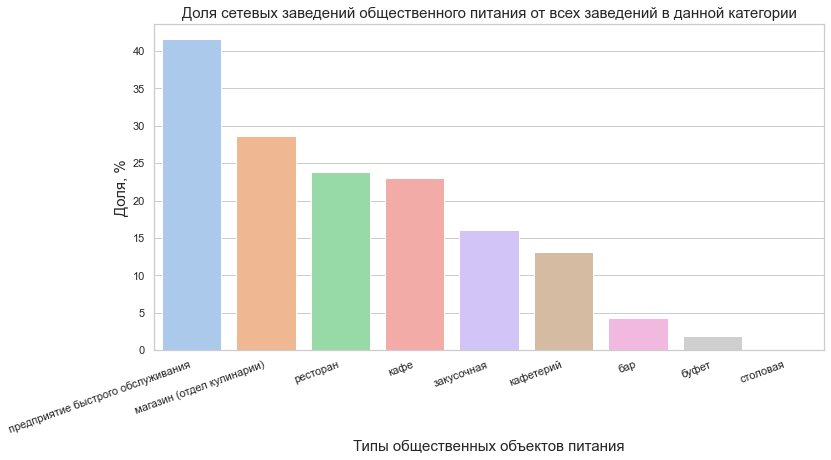

In [29]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='object_type', y='id',
                 data=((test_data[test_data['chain'] == 
           'да'].groupby('object_type')['id'].count() / test_data.groupby('object_type')['id'].count()) *100
).sort_values(ascending=False).reset_index())
ax.set_title('Доля сетевых заведений общественного питания от всех заведений в данной категории', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Доля, %', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

Мы видим, что если смотреть на доли, то больше всего сетевых объектов среди заведений быстрого обслуживания, кулинарии и ресторанов. Меньше всего баров, буфетов и столовых, как и на графике сетевых общественных заведений. 

### Теперь посмотрим, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Для этого создадим датафрейм с количеством заведений и средним количеством посадочных мест и построим диаграмму рассеяния

In [30]:
scat_data = test_data[test_data['chain'] == 'да'].groupby('object_name').agg(count_oop=('object_name', 'count'), 
                               mean_seats=('seats', 'mean')).reset_index().sort_values(by='count_oop', ascending=False)

<Figure size 864x432 with 0 Axes>

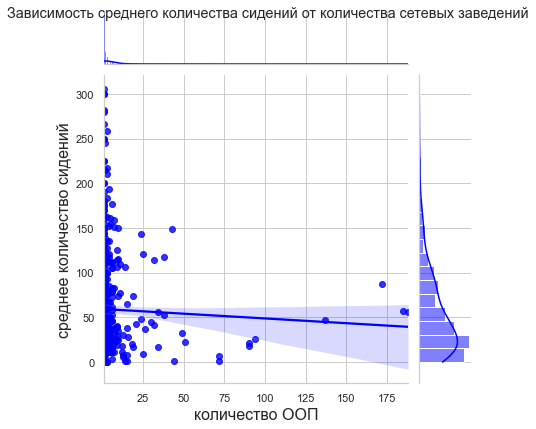

In [31]:
plt.figure(figsize=(12, 6)) 
ax = sns.jointplot(x='count_oop', y='mean_seats', data=scat_data, kind='reg', color='blue') 
ax.fig.suptitle("Зависимость среднего количества сидений от количества сетевых заведений")
ax.set_axis_labels('количество ООП', 'среднее количество сидений', fontsize=16)
plt.show()


Большая часть сетевых заведений имеет не более 20 точек, среднее количество мест в которых варьируется, но большая часть лежит в пределах от 0 до 100 мест. В больших сетях, где более 40 точек среднее количество мест лежит в пределах от 0 до 50, то есть это точки с небольшим количеством мест

### Найдем  среднее количество посадочных мест для каждого вида объекта общественного питания

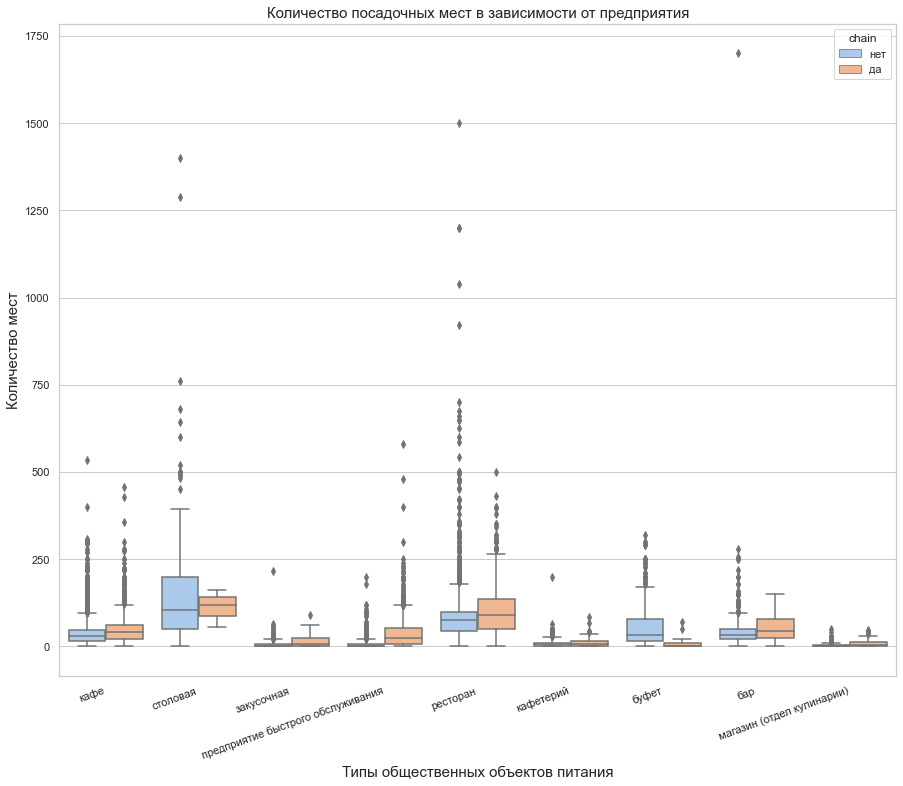

In [32]:
plt.figure(figsize=(15, 12)) 
ax = sns.boxplot(x='object_type', y='seats', hue='chain', data=test_data) 

ax.set_title('Количество посадочных мест в зависимости от предприятия', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Количество мест', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

Боксплоты становится трудно интерпретировать из-за большого количества выбросов. Изменим вертикальную шкалу для более подробного рассмотрения боксплотов

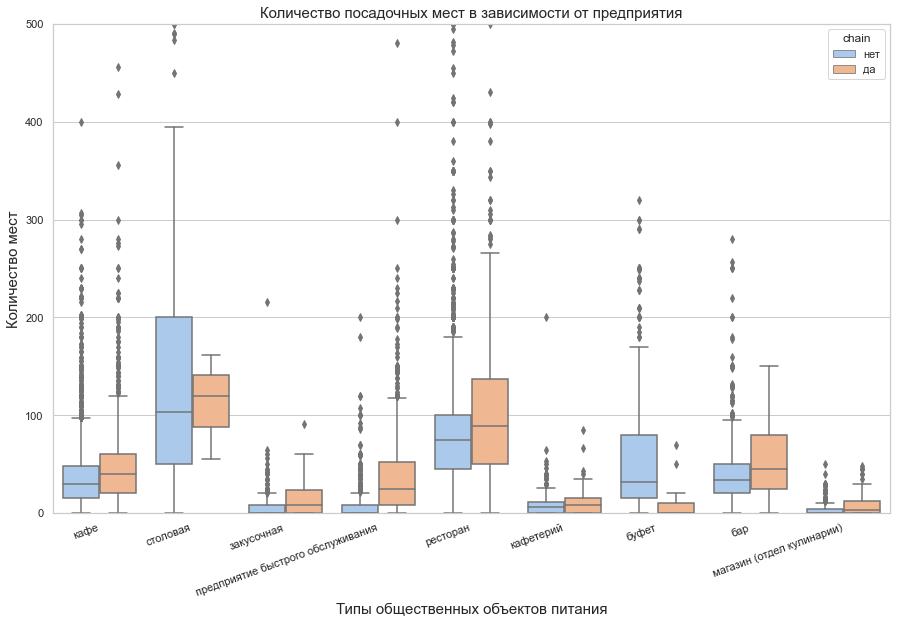

In [33]:
plt.figure(figsize=(15, 9)) 
ax = sns.boxplot(x='object_type', y='seats', hue='chain', data=test_data) 

ax.set_title('Количество посадочных мест в зависимости от предприятия', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Количество мест', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_ylim([0,500])
plt.show()

Видно, что наибольший дипазон разброса по количеству мест у несетевых заведений. Самый большой разброс принадлежит категории рестораны, затем идет категория столовых и категория кафе. В отделе кулинарии, кафетериях и закусочных аномально большие значения количества мест практически отсутствуют. Посмотрим на средние значения

In [34]:
test_data.groupby(['object_type', 'chain']).agg(mean_seats=('seats',
                        'mean')).sort_values(by='mean_seats', ascending=False).reset_index()

,object_type,chain,mean_seats
0,столовая,нет,130.358776
1,столовая,да,112.333333
2,ресторан,да,100.362799
3,ресторан,нет,95.798735
4,бар,да,53.027027
5,буфет,нет,52.178761
6,кафе,да,47.426934
7,бар,нет,43.103912
8,предприятие быстрого обслуживания,да,40.319797
9,кафе,нет,37.503957


И на средние значения по разбивке на сетевые и не сетевые

In [35]:
test_chain = test_data.groupby(['object_type', 'chain']).agg(mean_seats=('seats',
                        'mean')).sort_values(by='mean_seats', ascending=False).reset_index()

print('Среднее количество посадочных мест по сетевым заведением составило', test_chain[test_chain['chain'] == 'да'].mean())
print('Среднее количество посадочных мест по несетевым заведением составило', test_chain[test_chain['chain'] == 'нет'].mean())

Среднее количество посадочных мест по сетевым заведением составило mean_seats    44.613431
dtype: float64
Среднее количество посадочных мест по несетевым заведением составило mean_seats    42.839564
dtype: float64


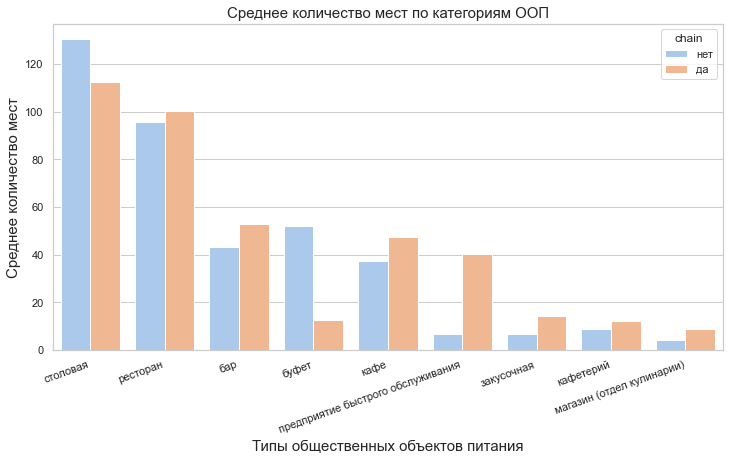

In [36]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='object_type', y='mean_seats', hue='chain',
                 data=test_data.groupby(['object_type', 'chain']).agg(mean_seats=('seats',
                        'mean')).sort_values(by='mean_seats', ascending=False).reset_index())
                 
ax.set_title('Среднее количество мест по категориям ООП', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Среднее количество мест', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

Наибольшее среднее количество посадочных мест у несетевых столовых (около 130), затем у сетевых (112). Далее идут сетевые (100) и несетевые (95) рестораны. Наименьшие средние количества посадочных мест у кулинарии в магазинах. Вторые и третьи с конца - кафетерии и закусочные. У сетевых предприятий быстрого обслуживания много посадочных мест (40) по сравнению с несетевыми (7). У кафе данный показатель равен 47 для сетевых и 37 для несетевых.

### График топ-10 улиц по количеству объектов общественного питания

Для начала выделим столбец в котором будут названия улицы

In [37]:
#проведем некоторые преобразования чтобы проще было выделить улицу
symbols = [',', '«', '»', '(', ')', '"', '  ']

for s in symbols:
    test_data['address'] = test_data['address'].str.replace(s, ' ')
test_data['address'] = test_data['address'].str.replace('ё','е')

In [38]:
# преобразуем столбец в список, и удалим из него информацию о городе и доме
# затем преобразуем обратно

address = test_data['address'].to_list()
streets = []

for street in address:  
    start = street.find('город москва')
    end = street.find('дом ')
    streets.append(street[start+14:end-1])

test_data['street_name'] = streets    
test_data.head(10)    

,id,object_name,chain,object_type,address,seats,street_name
0,151635,сметана,нет,кафе,город Москва улица Егора Абакумова дом 9,48,улица Егора Абакумова
1,77874,родник,нет,кафе,город Москва улица Талалихина дом 2/1 корпус 1,35,улица Талалихина
2,24309,кафе «академия»,нет,кафе,город Москва Абельмановская улица дом 6,95,Абельмановская улица
3,21894,пиццетория,да,кафе,город Москва Абрамцевская улица дом 1,40,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,город Москва Абрамцевская улица дом 9 корпус 1,50,Абрамцевская улица
5,27429,стол. при гоу сош № 1051,нет,столовая,город Москва Абрамцевская улица дом 15 корпус 1,240,Абрамцевская улица
6,148815,брусника,да,кафе,город Москва переулок Сивцев Вражек дом 6/2,10,переулок Сивцев Вражек
7,20957,буфет мтуси,нет,столовая,город Москва Авиамоторная улица дом 8 строение 1,90,Авиамоторная улица
8,20958,кпф семья-1,нет,столовая,город Москва Авиамоторная улица дом 8 строение 1,150,Авиамоторная улица
9,28858,столовая мтуси,нет,столовая,город Москва Авиамоторная улица дом 8 строение 1,120,Авиамоторная улица


Найдем топ10 улиц по количеству ресторанов

In [39]:
top_10 = test_data.groupby(['street_name']).agg(count_oop=('object_name', 
                'count')).sort_values(by='count_oop', ascending=False).reset_index().head(10)
top_10.head()

,street_name,count_oop
0,проспект Мира,203
1,Профсоюзная улица,181
2,Ленинградский проспект,169
3,Пресненская набережная,167
4,Варшавское шоссе,155


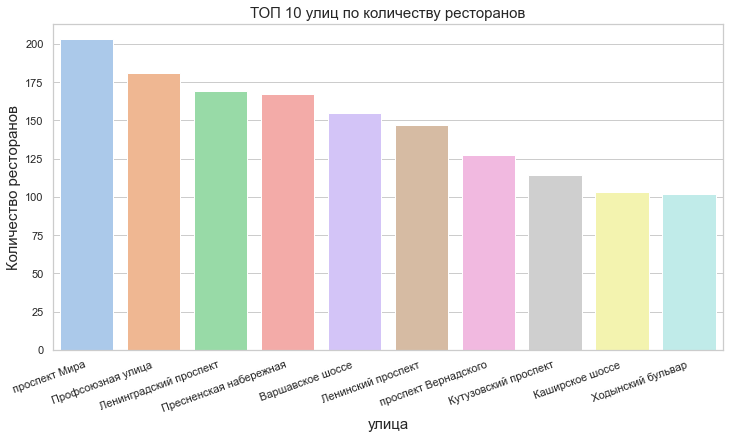

In [40]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='street_name', y='count_oop', data=top_10)
ax.set_title('ТОП 10 улиц по количеству ресторанов', fontsize=15)
ax.set_xlabel('улица', fontsize=15)
ax.set_ylabel('Количество ресторанов', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

В ТОП 10 улиц по количеству ресторанов вошли следующие улицы:
1. **проспект Мира** ( районы Алексеевский, Марьина роща, Ярославский, Останкинский, Ростокино, Свиблово, Мещанский)

2. **Профсоюзная улица** ( районы Академический, Черемушки, Ясенево, Обручево, Коньково, Теплый Стан)

3. **Ленинградский проспект** ( районы Беговой, Аэропорт, Сокол, Хорошевский)

4. **Пресненская набережная** ( район Пресненский)

5. **Варшавское шоссе** ( район Северного, Центрального и Южного Чертаново, Донской, Нагатино-Садовники, Нагорный, Южное и Северное Бутово)

6. **Ленинский проспект** ( район Проспект Вернадского, Тропарево-Никулино, Донской, Гагаринский, Ломоносовский, Обручевский, Теплый Стан, Якиманка)

7. **проспект Вернандского** ( район Проспект Вернадского, Тропарево-Никулино, Раменки, Гагаринский, Ломоносовский)

8. **Кутузовский проспект** (район Дорогомилово, Фили-Давыдково)

9. **Каширское шоссе** (район Москворечье-Сабурово, Нагатино-Садовники,Орехово-Борисово Южное и Северное)

10. **Ходынский бульвар** ( район Северного, Центрального и Южного Чертаново)

Как мне кажется основное их сходство - все это основные автомобильные дороги Москвы, по которым в день проезжает огромное число людей. Заведением общественного питания выгодно открываться рядом с большим потоком людей, и когда люди на транспорте они могут с легкостью остановиться в заведении, если проголодаются.

Также эти улицы очень длинные и захватывают многие районы.

Сделаем автоматическое сопоставление улиц с районами Москвы, для этого загрузим таблицу с информацией о районах

In [41]:
from io import BytesIO
import requests
spreadsheet_id = '1E_dqNS92qe1hdLYQg8R7i7X1ozlhWzeWNM_NcQpv0Is'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


И получим из загруженного датафрейма районы, через которые проходят наши топ10 улиц

In [42]:
top10_areas = df[df['streetname'].isin(top_10['street_name'])].sort_values(by=['streetname', 'area'])
top10_areas.head()

,streetname,areaid,okrug,area
3241,Варшавское шоссе,99,ЮАО,Донской район
3349,Варшавское шоссе,104,ЮАО,Нагорный район
3305,Варшавское шоссе,102,ЮАО,Район Нагатино-Садовники
3999,Варшавское шоссе,130,ЮЗАО,Район Северное Бутово
3117,Варшавское шоссе,108,ЮАО,Район Чертаново Северное


### Анализ улиц с одним объектом общественного питания

In [43]:
data_street = test_data.groupby(['street_name']).agg(count_oop=('object_name', 
                'count')).sort_values(by='count_oop').reset_index()
data_street[data_street['count_oop'] == 1].sum()

street_name    Спортивный проездСпартаковский переулокСоюзный...
count_oop                                                    827
dtype: object

Поскольку нашлось целых 826 улиц с одним ООП, возьмем первые 10 из них для анализа

In [44]:
data_street[1:11]

,street_name,count_oop
1,Спортивный проезд,1
2,Спартаковский переулок,1
3,Союзный проспект,1
4,Софийская набережная,1
5,Сосновая аллея,1
6,Сормовский проезд,1
7,Средний Кондратьевский переулок,1
8,Солнечногорский проезд,1
9,Соймоновский проезд,1
10,Скорняжный переулок,1


Районы на которых расположены улицы:
1. Спартаковский переулок - Басманном район - длина улицы 500 метров
2. Союзный проспект - Новогиреево - длина улицы 1.2 километра
3. Софийская набережная	- Якиманка - длина улицы 800 метров
4. Сосновая аллея - Покровское-Стрешнево - длина улицы 780 метров
5. Сормовский проезд - Выхино-Жулебино - длина улицы 433 метра
6. Солнечногорский проезд - Головинский район - длина улицы 550 метров
7. Спортивный проезд - Люблино - длина улицы 340 метров
8. Соколово-Мещерская улица - Куркино - длина улицы 1.75 километров
9. Скорняжный переулок - Красносельский район - длина улицы 340 метров
10. Скатертный переулок - Пресненский район - длина улицы 650 метров

Исходя из этих данных можно сказать, что один объект ООП находится на маленьких пешеходных улицах

Аналогично получим автоматическое сопоставление для улиц с одним объектом общественного питания

In [45]:
one_oop_areas = df[df['streetname'].isin(data_street['street_name'])].sort_values(by=['streetname', 'area'])
one_oop_areas.head()

,streetname,areaid,okrug,area
3145,1-й Автозаводский проезд,98,ЮАО,Даниловский район
1829,1-й Амбулаторный проезд,54,САО,Район Аэропорт
1834,1-й Балтийский переулок,54,САО,Район Аэропорт
805,1-й Басманный переулок,13,ЦАО,Басманный район
4213,1-й Басманный переулок,15,ЦАО,Красносельский район


### Анализ распределения количества посадочных мест для улиц с большим количеством объектов общественного питания

Будем работать с нашим ТОП 10 улиц для анализа данного вопроса

In [46]:
data_top10 = test_data[test_data['street_name'].isin(top_10['street_name'])]
data_top10.head()

,id,object_name,chain,object_type,address,seats,street_name
151,155973,кафе «андерсон»,да,кафе,город Москва Варшавское шоссе дом 2,150,Варшавское шоссе
152,23618,кафе «subway»,да,кафе,город Москва Варшавское шоссе дом 7 корпус 1,36,Варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,город Москва Варшавское шоссе дом 29,30,Варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,город Москва Варшавское шоссе дом 72 корпус 2,0,Варшавское шоссе
155,120658,выпечка,нет,кафетерий,город Москва Варшавское шоссе дом 100,2,Варшавское шоссе


In [47]:
print('Среднее количество посадочных мест по сетевым заведением ТОП 10 составило', 
      data_top10[data_top10['chain']=='да']['seats'].mean())

print('Среднее количество посадочных мест по несетевым заведением ТОП 10 составило', 
      data_top10[data_top10['chain']=='нет']['seats'].mean())

Среднее количество посадочных мест по сетевым заведением ТОП 10 составило 52.956756756756754
Среднее количество посадочных мест по несетевым заведением ТОП 10 составило 56.72677595628415


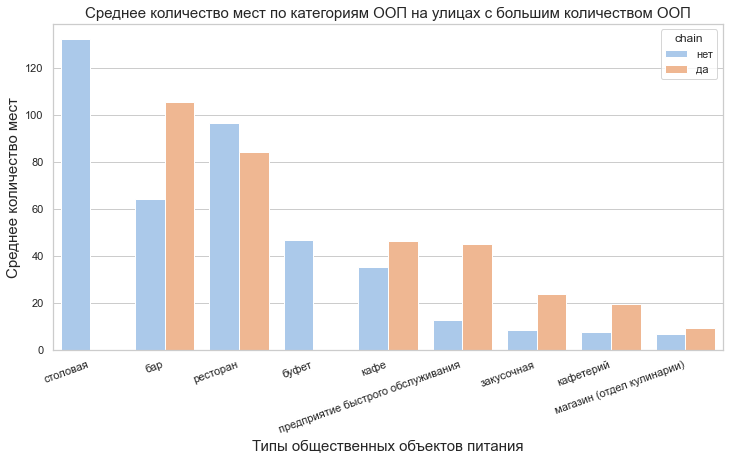

In [48]:
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='object_type', y='mean_seats', hue='chain',
                 data=data_top10.groupby(['object_type', 'chain']).agg(mean_seats=('seats',
                        'mean')).sort_values(by='mean_seats', ascending=False).reset_index())
                 
ax.set_title('Среднее количество мест по категориям ООП на улицах с большим количеством ООП', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Среднее количество мест', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

Мы видим что по количеству средних мест на ТОП 10 улицах лидируют столовые, причем сетевые столовые отсутствуют. Затем идут бары, рестораны, буфет, кафе. На последнем месте кафетерии и кулинария. В целом посадочных мест заметно меньше, по сравнению со всеми данными. Посмотрим на боксплот

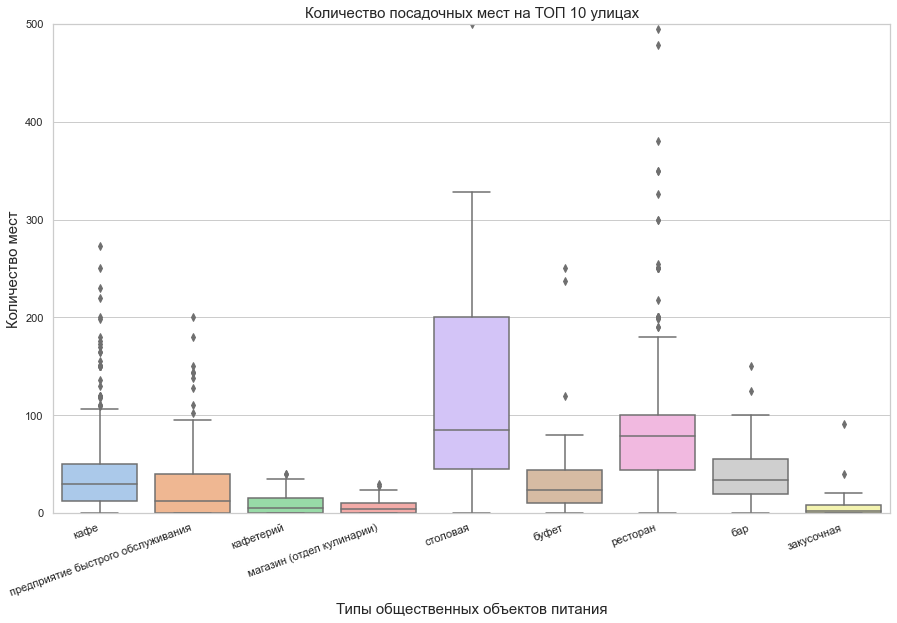

In [49]:
plt.figure(figsize=(15, 9)) 
ax = sns.boxplot(x='object_type', y='seats', data=data_top10) 

ax.set_title('Количество посадочных мест на ТОП 10 улицах', fontsize=15)
ax.set_xlabel('Типы общественных объектов питания', fontsize=15)
ax.set_ylabel('Количество мест', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_ylim([0,500])
plt.show()

Мы видим что на ТОП 10 улицах количество выбросов и больших значений заметно меньше. Возможно это связано с высокими ценами аренды на помещения вследствие большой конкуренции

### Вывод

1. Сначала мы проанализировали столбчатую диаграмму количества заведений каждого вида предприятия.  Мы увидели, что большинство объектов общественного питания в Москве это кафе (больше 6000). С большим отрывом от кафе и почти наравне идут столовые, рестораны и преприятия быстрого обслуживания. На последнем месте находятся отделы кулинарии в магазинах, на втором и третьем с конца - закусочные и кафетерии.

2. Затем чтобы понять сколько у нас сетевых и несетевых объектов мы построили круговую диаграмму и получили, что 81 % заведений в Москве - несетевые, и лишь 19 % сети питания. 

3. Далее мы работали с сетевыми предприятиями. Анализируя столбчатые диаграммы мы сделали вывод, что Среди сетевых заведений на первом месте находятся кафе, затем идут предприятия быстрого обслуживания, затем рестораны. Замыкают рейтинг столовые, буфеты и бары. Данный результат похож на тот, что мы получили, анализируя весь датасет. Однако, если визуализировать долю сетевых заведений от всех с разбивкой на типы, то мы получим другой результат - наибольшая доля сетевых объектов принадлежит заведениям быстрого обслуживания, кулинарии и ресторанам. Меньше всего баров, буфетов и столовых, как и на графике сетевых общественных заведений.

4. Затем было выяснено (используя джоинплот и боксплоты), что большая часть сетевых заведений имеет не более 20 точек, среднее количество мест в которых варьируется, но большая часть лежит в пределах от 0 до 100 мест. В больших сетях, где более 40 точек среднее количество мест лежит в пределах от 0 до 50, то есть это точки с небольшим количеством мест. Наибольший дипазон разброса среднего количества мест посадки у несетевых заведений. Самый большой разброс принадлежит категории рестораны, затем идет категория столовых и категория кафе. В отделе кулинарии, кафетериях и закусочных аномально большие значения количества мест практически отсутствуют. Посмотрим на средние значения. Наибольшее среднее количество посадочных мест у несетевых столовых (около 130), затем у сетевых (112). Далее идут сетевые (100) и несетевые (95) рестораны. Наименьшие средние количества посадочных мест у кулинарии в магазинах. Вторые и третьи с конца - кафетерии и закусочные. У сетевых предприятий быстрого обслуживания много посадочных мест (40) по сравнению с несетевыми (7). У кафе данный показатель равен 47 для сетевых и 37 для несетевых.

5. Далее мы построили график ТОП 10 улиц с наибольшим количеством ресторанов в Москве. Мы получили, что:
    В ТОП 10 улиц по количеству ресторанов вошли следующие улицы:
            - проспект Мира ( районы Алексеевский, Марьина роща, Ярославский, Останкинский, Ростокино, Свиблово, Мещанский)
            - Профсоюзная улица ( районы Академический, Черемушки, Ясенево, Обручево, Коньково, Теплый Стан)
            - Ленинградский проспект ( районы Беговой, Аэропорт, Сокол, Хорошевский)
            - Пресненская набережная ( район Пресненский)
            - Варшавское шоссе ( район Северного, Центрального и Южного Чертаново, Донской, Нагатино-Садовники, Нагорный, Южное и Северное Бутово)
            - Ленинский проспект ( район Проспект Вернадского, Тропарево-Никулино, Донской, Гагаринский, Ломоносовский, Обручевский, Теплый Стан, Якиманка)
            - проспект Вернандского ( район Проспект Вернадского, Тропарево-Никулино, Раменки, Гагаринский, Ломоносовский)
            - Кутузовский проспект (район Дорогомилово, Фили-Давыдково)
            - Каширское шоссе (район Москворечье-Сабурово, Нагатино-Садовники,Орехово-Борисово Южное и Северное)
            - Ходынский бульвар ( район Северного, Центрального и Южного Чертаново)

Наше предположение, что самые прибыльные районы в городе это улицы с основными автомобильными дорогами Москвы, по которым в день проезжает огромное число людей. Заведением общественного питания выгодно открываться рядом с большим потоком людей, и когда люди на транспорте они могут с легкостью остановиться в заведении, если проголодаются.Также эти улицы очень длинные и захватывают многие районы.

6. Среди улиц с одним ООП также был выделен ТОП 10.Районы на которых расположены улицы:
            - Спартаковский переулок - Басманном район - длина улицы 500 метров
            - Союзный проспект - Новогиреево - длина улицы 1.2 километра
            - Софийская набережная - Якиманка - длина улицы 800 метров
            - Сосновая аллея - Покровское-Стрешнево - длина улицы 780 метров
            - Сормовский проезд - Выхино-Жулебино - длина улицы 433 метра
            - Солнечногорский проезд - Головинский район - длина улицы 550 метров
            - Спортивный проезд - Люблино - длина улицы 340 метров
            - Соколово-Мещерская улица - Куркино - длина улицы 1.75 километров
            - Скорняжный переулок - Красносельский район - длина улицы 340 метров
            - Скатертный переулок - Пресненский район - длина улицы 650 метров
Исходя из этих данных можно сказать, что один объект ООП находится на маленьких пешеходных улицах. 

7. При анализе распределения количества посадочных мест для улиц с большим количеством объектов общественного питания мы увидели, что по количеству средних мест на ТОП 10 улицах лидируют столовые, причем сетевые столовые отсутствуют. Затем идут бары, рестораны, буфет, кафе. На последнем месте кафетерии и кулинария. В целом посадочных мест заметно меньше, по сравнению со всеми данными. Возможно это связано с высокими ценами аренды на помещения вследствие большой конкуренции.

## Общий вывод

1. В процессе знакомства с данными не было найдено проблем (дубликатов, пропусков и т.д.). Названия колонок написаны в стиле snake-case, удобно читаются и передают суть информации, лежащей в них, за исключением колонки с количеством посадочных мест, которая была переименована. Также столбец **object_name** был приведен к нижнему регистру и из него были убраны дубликаты по макдональдсу, kfc, шоколаднице. Были удалены 85 дубликатов из датафрейма
2. Затем в процессе анализа данных мы получили следующие выводы
    1. Самые популярные объекты ООП это кафе, столовые и рестораны. Самые непопулярные - кулинарии в магазинах, закусочные и кафетерии
    2. Деление в москве на сетевые и несетевые объекты - 81 к 19 процентам. Среди сетевых заведений в Москве больше всего заведений быстрого обслуживания, кулинарии и ресторанов. Меньше всего - баров, буфетов и столовых. Однако если смотреть на доли, то оказалось, что наибольшая доля сетевых объектов принадлежит заведениям быстрого обслуживания, кулинарии и ресторанам. Меньше всего баров, буфетов и столовых, как и на графике сетевых общественных заведений.
    3.Большая часть сетевых заведений имеет не более 20 точек, среднее количество мест в которых варьируется, но большая часть лежит в пределах от 0 до 100 мест. В больших сетях, где более 40 точек среднее количество мест лежит в пределах от 0 до 50, то есть это точки с небольшим количеством мест. Среднее количество посадочных мест по сетевым заведениям 44, по несетевым 43. 
    4. Затем мы нашли топ 10 улиц по количеству ООП, основное сходство - все это основные автомобильные дороги Москвы, по которым в день проезжает огромное число людей. Заведением общественного питания выгодно открываться рядом с большим потоком людей, и когда люди на транспорте они могут с легкостью остановиться в заведении, если проголодаются. Также эти улицы очень длинные и захватывают многие районы. Среднее количество посадочных мест по сетевым заведениям 53, по несетевым 56. По количеству средних мест на ТОП 10 улицах лидируют столовые, причем сетевые столовые отсутствуют. Затем идут бары, рестораны, буфет, кафе. На последнем месте кафетерии и кулинария. В целом посадочных мест заметно меньше, по сравнению со всеми данными. Возможно это связано с высокими ценами аренды на помещения вследствие большой конкуренции.
    5. Улицы на которых находится 1 объект ООП - маленькие пешеходные улицы. 

## Рекомендации

Мы открываем небольшое кафе в Москве. Оно имеет особенность  — гостей должны обслуживать роботы. 
Исходя из анализа кафе является самым популярным объектом пищевой инфраструктуры в Москве. Также наше кафе несетевое, в Москве большая часть ООП является несетевым заведением. Это значит что мы правильно выбрали самую популярную нишу, но и самую конкурентную. 
Касаемо расположения, я бы рекомендовала открыть кафе в ТОП 10  популярных улиц, ввследствие высокого потока клиентов. Однако тут также есть угроза в виде конкуренции и большой арендной платы. Следует продолжить анализ по перспективным районам чтобы уточнить более оптимальное местоположение (может быть какие-то развивающиеся районы). По количеству средних мест стоит выбрать число в районе 40-60 посадочных мест. 
Данная тактика подойдет при большом вливании денег инвесторов, так как мы планируем врываться в самую конкурентную нишу, и ООП объекты ООП окупаются не сразу. 